# Advanced VLM Analysis: smolVLA

This notebook provides a deep dive into the **smolVLA** model, focusing on:
1.  **Architecture Visualization**: Understanding the components.
2.  **Weight Analysis**: Distribution, sparsity, and patterns.
3.  **Activation Analysis**: Simulating forward passes to inspect feature maps.
4.  **Advanced Roofline Modeling**: Layer-wise performance bounds.
5.  **Quantization Impact**: Simulating Int8 vs. FP16 accuracy.

## Setup & Imports

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# Set plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (12, 6),
    'figure.dpi': 150
})

# Constants
BASE_WEIGHTS_FOLDER = "../model-preparation/full/npy_generation/data"
LAYER_PREFIX = "model.vlm_with_expert.vlm.model.vision_model.encoder.layers.11.self_attn"

print("Environment Setup Complete.")


Environment Setup Complete.


## 1. Model Architecture

We define the `TinySelfAttn` module, which represents a single self-attention layer of the Vision Encoder. This module includes:
*   **Q, K, V Projections**: Linear layers mapping inputs to queries, keys, and values.
*   **Scaled Dot-Product Attention**: Computing attention scores.
*   **Output Projection**: Mixing the attended features.

In [7]:
class TinySelfAttn(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim

        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=True)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=True)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=True)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=True)

    def _shape(self, x, bsz, seq_len):
        return x.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

    def forward(self, x, attn_mask=None):
        bsz, seq_len, _ = x.size()
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self._shape(q, bsz, seq_len)
        k = self._shape(k, bsz, seq_len)
        v = self._shape(v, bsz, seq_len)

        attn_scores = (q @ k.transpose(-1, -2)) / math.sqrt(self.head_dim)
        if attn_mask is not None:
            attn_scores += attn_mask
        attn_probs = attn_scores.softmax(dim=-1)

        ctx = attn_probs @ v
        ctx = ctx.transpose(1, 2).contiguous().view(bsz, seq_len, self.embed_dim)
        out = self.out_proj(ctx)
        return out, attn_probs

def load_numpy_weights(prefix: str):
    folder_path = BASE_WEIGHTS_FOLDER
    split_prefix = prefix.split('.')
    for part in split_prefix:
        folder_path = os.path.join(folder_path, part)
    
    weight_dict = {}
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".npy"):
                file_path = os.path.join(root, filename)
                weight_dict[os.path.relpath(file_path, folder_path)] = np.load(file_path)
    return weight_dict

# Load Weights
try:
    layer_weights = load_numpy_weights(LAYER_PREFIX)
    print(f"Loaded {len(layer_weights)} weight files.")
except FileNotFoundError:
    print("Weight files not found. Using random initialization for demonstration.")
    layer_weights = {}

# Initialize Model
model = TinySelfAttn(embed_dim=768, num_heads=12).to(torch.bfloat16)

if layer_weights:
    with torch.no_grad():
        model.q_proj.weight.copy_(torch.tensor(layer_weights["q_proj/weight.npy"], dtype=torch.bfloat16))
        model.q_proj.bias.copy_(torch.tensor(layer_weights["q_proj/bias.npy"], dtype=torch.bfloat16))
        model.k_proj.weight.copy_(torch.tensor(layer_weights["k_proj/weight.npy"], dtype=torch.bfloat16))
        model.k_proj.bias.copy_(torch.tensor(layer_weights["k_proj/bias.npy"], dtype=torch.bfloat16))
        model.v_proj.weight.copy_(torch.tensor(layer_weights["v_proj/weight.npy"], dtype=torch.bfloat16))
        model.v_proj.bias.copy_(torch.tensor(layer_weights["v_proj/bias.npy"], dtype=torch.bfloat16))
        model.out_proj.weight.copy_(torch.tensor(layer_weights["out_proj/weight.npy"], dtype=torch.bfloat16))
        model.out_proj.bias.copy_(torch.tensor(layer_weights["out_proj/bias.npy"], dtype=torch.bfloat16))
    print("Weights loaded successfully.")


Loaded 8 weight files.
Weights loaded successfully.


## 2. Weight Analysis

We analyze the statistical properties of the weights. This helps in understanding the dynamic range required for quantization and identifying potential sparsity.

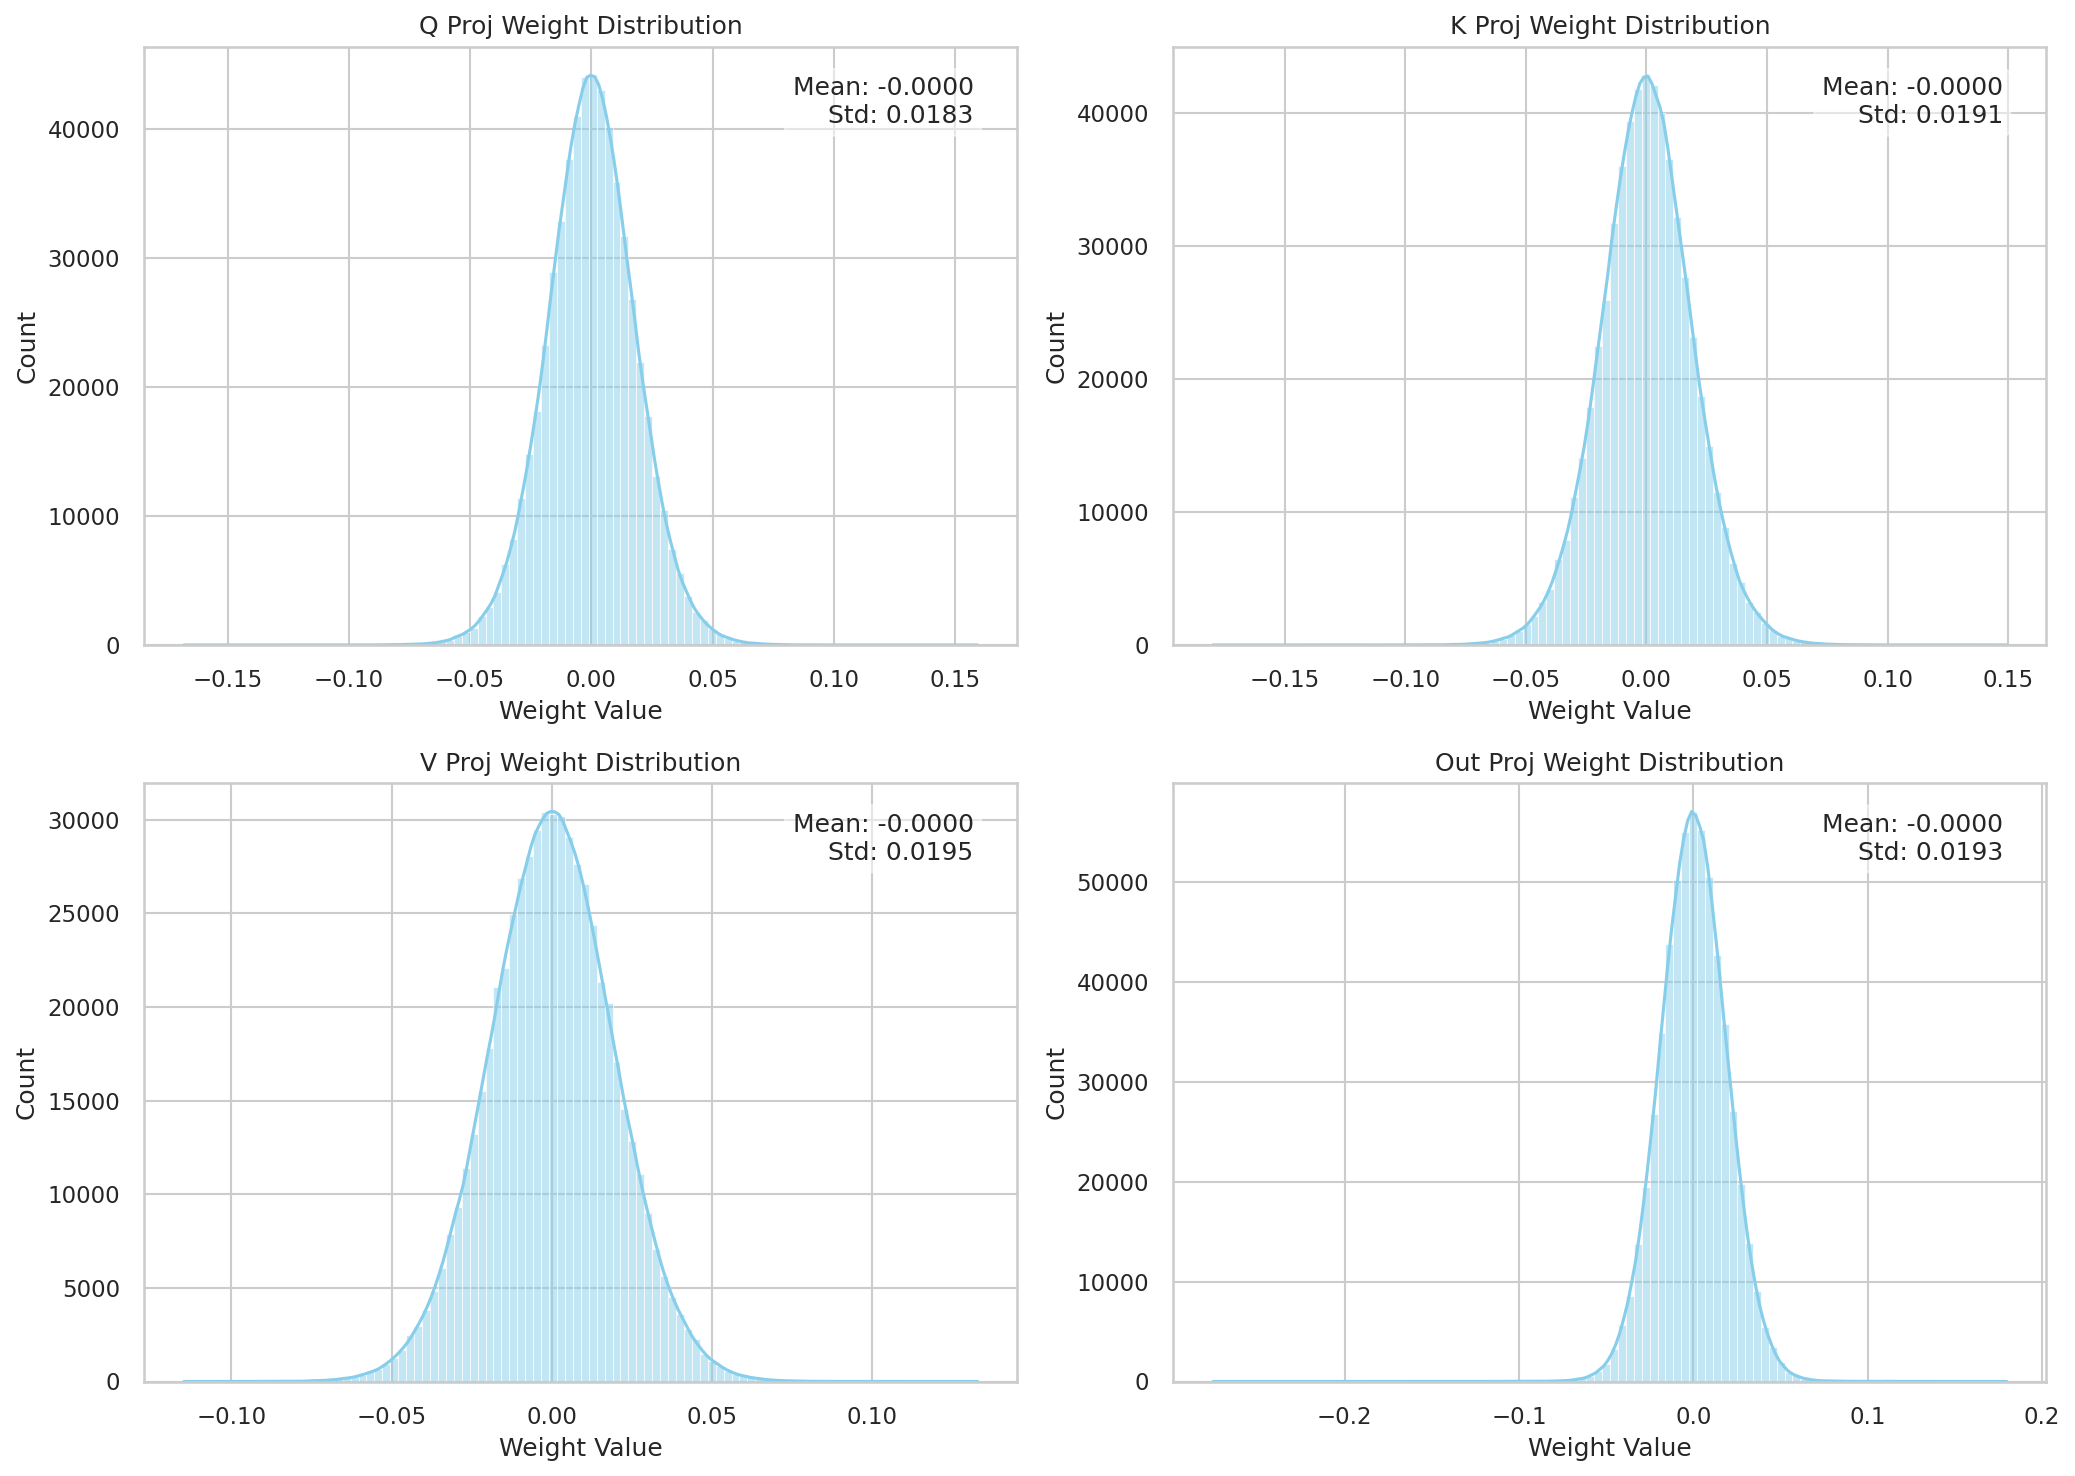

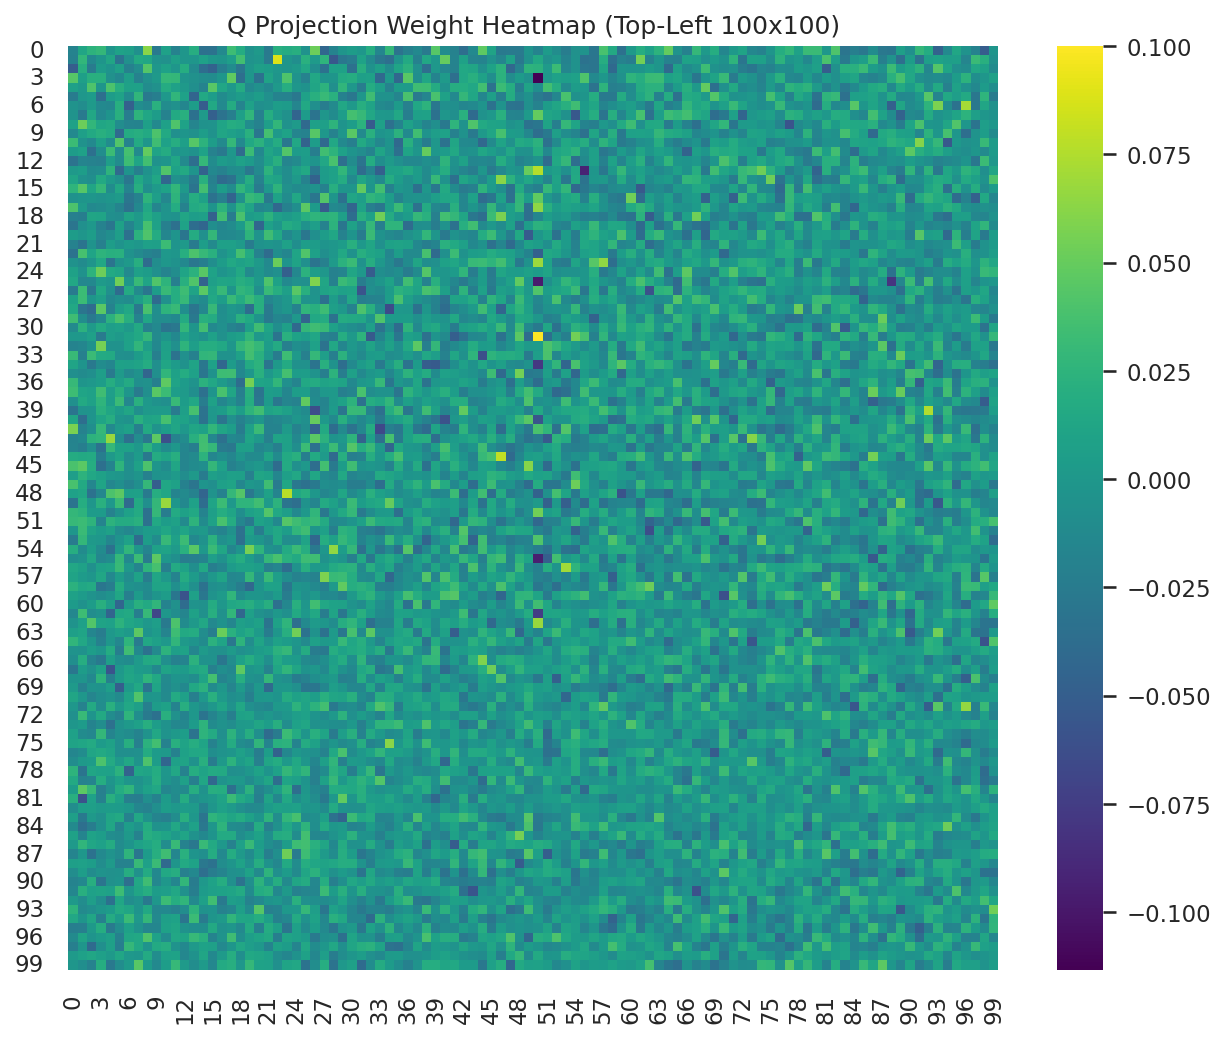

In [8]:
def plot_weight_distribution(model):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    layers = {
        'Q Proj': model.q_proj.weight,
        'K Proj': model.k_proj.weight,
        'V Proj': model.v_proj.weight,
        'Out Proj': model.out_proj.weight
    }
    
    for ax, (name, weight) in zip(axes.flatten(), layers.items()):
        w_np = weight.detach().float().numpy().flatten()
        sns.histplot(w_np, bins=100, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'{name} Weight Distribution')
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Count')
        
        # Stats
        mean = np.mean(w_np)
        std = np.std(w_np)
        ax.text(0.95, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', 
                transform=ax.transAxes, ha='right', va='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

def plot_weight_heatmap(model):
    fig, ax = plt.subplots(figsize=(10, 8))
    # Visualize Q Projection weights as an example
    w_np = model.q_proj.weight.detach().float().numpy()
    sns.heatmap(w_np[:100, :100], cmap='viridis', ax=ax) # Show subset for clarity
    ax.set_title('Q Projection Weight Heatmap (Top-Left 100x100)')
    plt.show()

plot_weight_distribution(model)
plot_weight_heatmap(model)


## 3. Activation Analysis

We simulate a forward pass with random inputs (mimicking embeddings) to observe the activation patterns, particularly the attention scores.

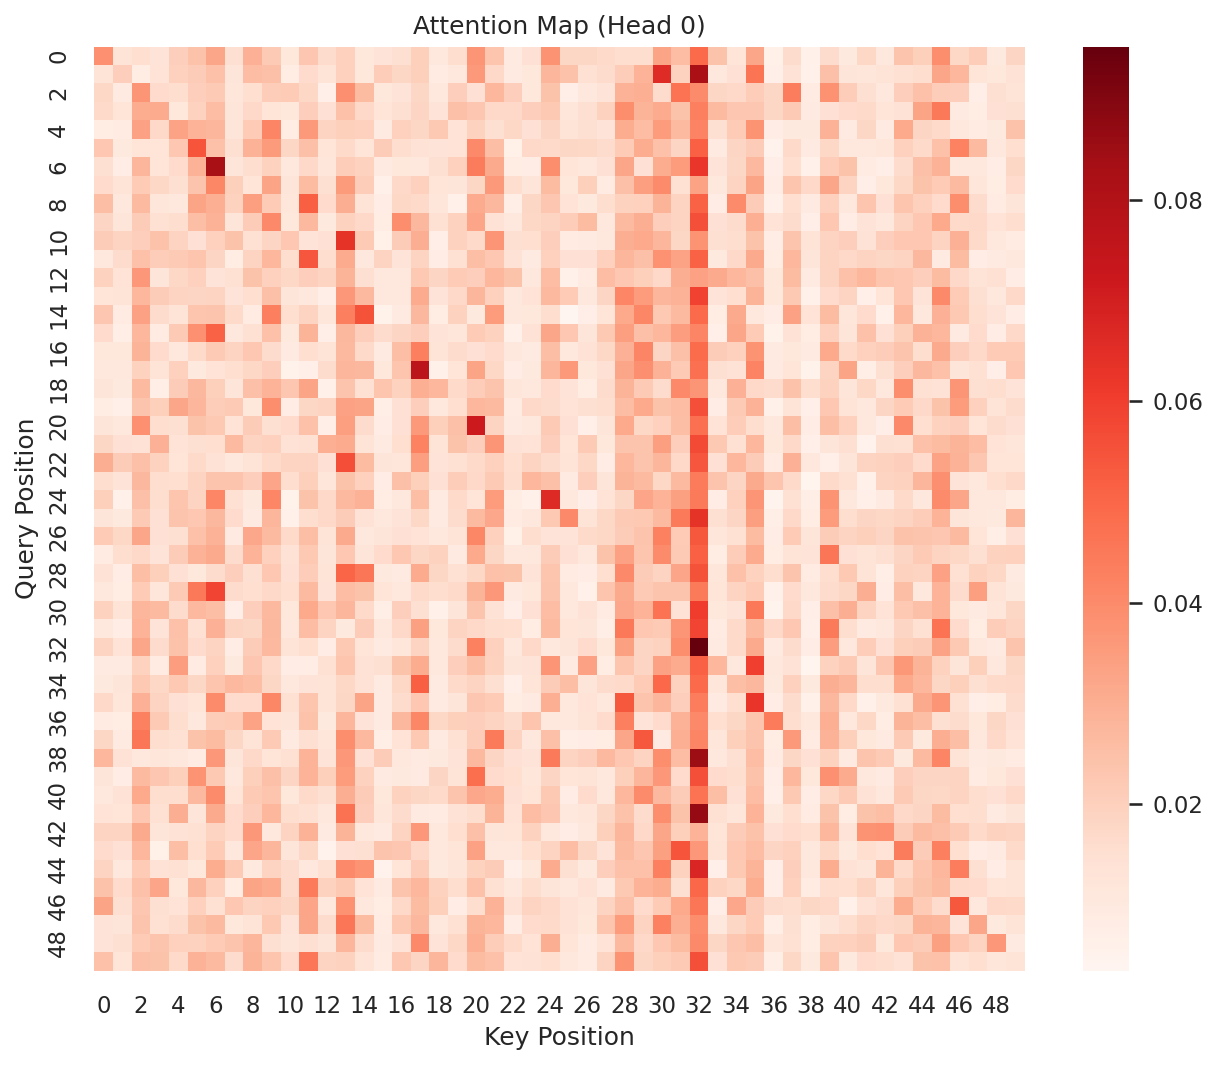

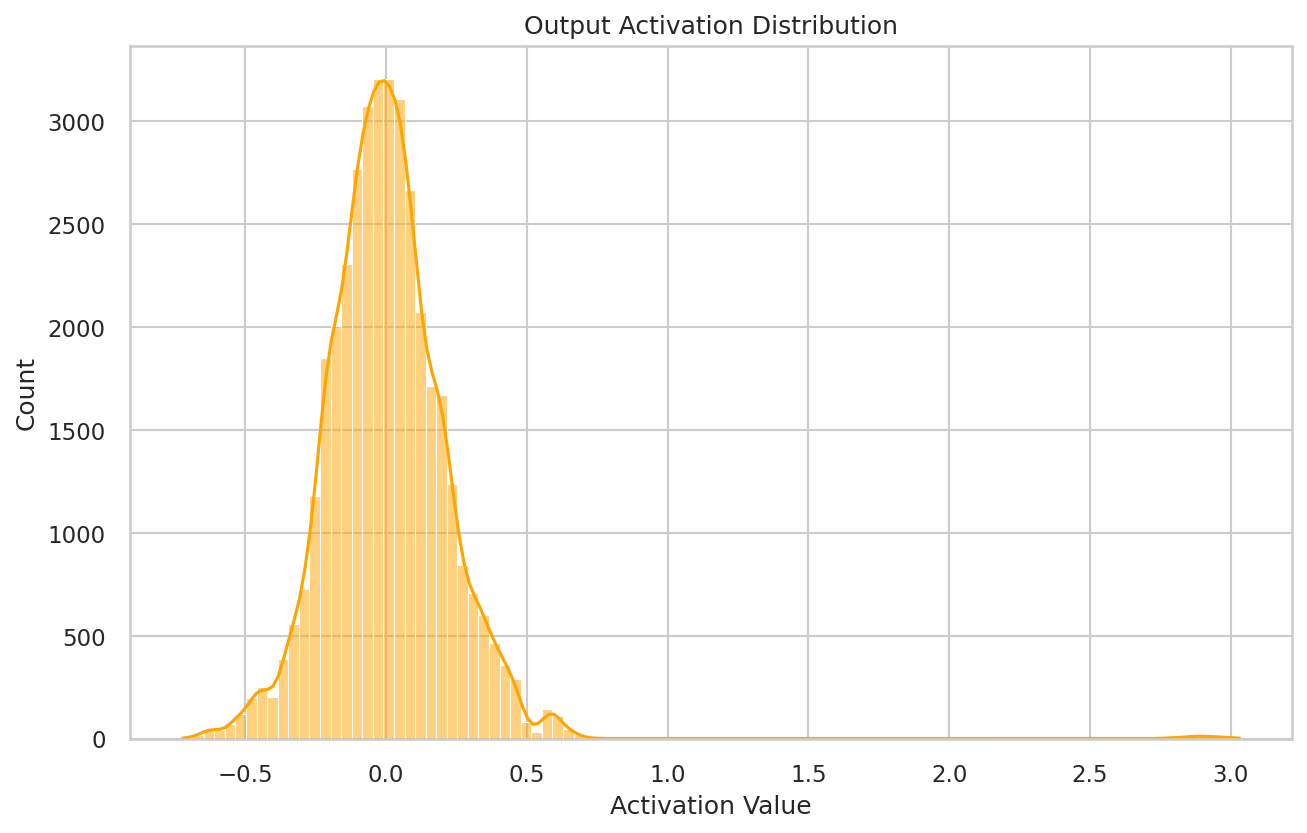

In [9]:
# Simulation
B, S, D = 1, 50, 768
x_input = torch.randn(B, S, D, dtype=torch.bfloat16)

with torch.no_grad():
    output, attn_probs = model(x_input)

# Visualize Attention Map (Head 0)
attn_map = attn_probs[0, 0].float().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(attn_map, cmap='Reds')
plt.title('Attention Map (Head 0)')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.show()

# Activation Histogram (Output)
out_np = output.float().numpy().flatten()
plt.figure(figsize=(10, 6))
sns.histplot(out_np, bins=100, kde=True, color='orange')
plt.title('Output Activation Distribution')
plt.xlabel('Activation Value')
plt.show()


## 4. Advanced Roofline Model

We analyze the theoretical performance limits for individual layers based on the Alveo U280 specifications.

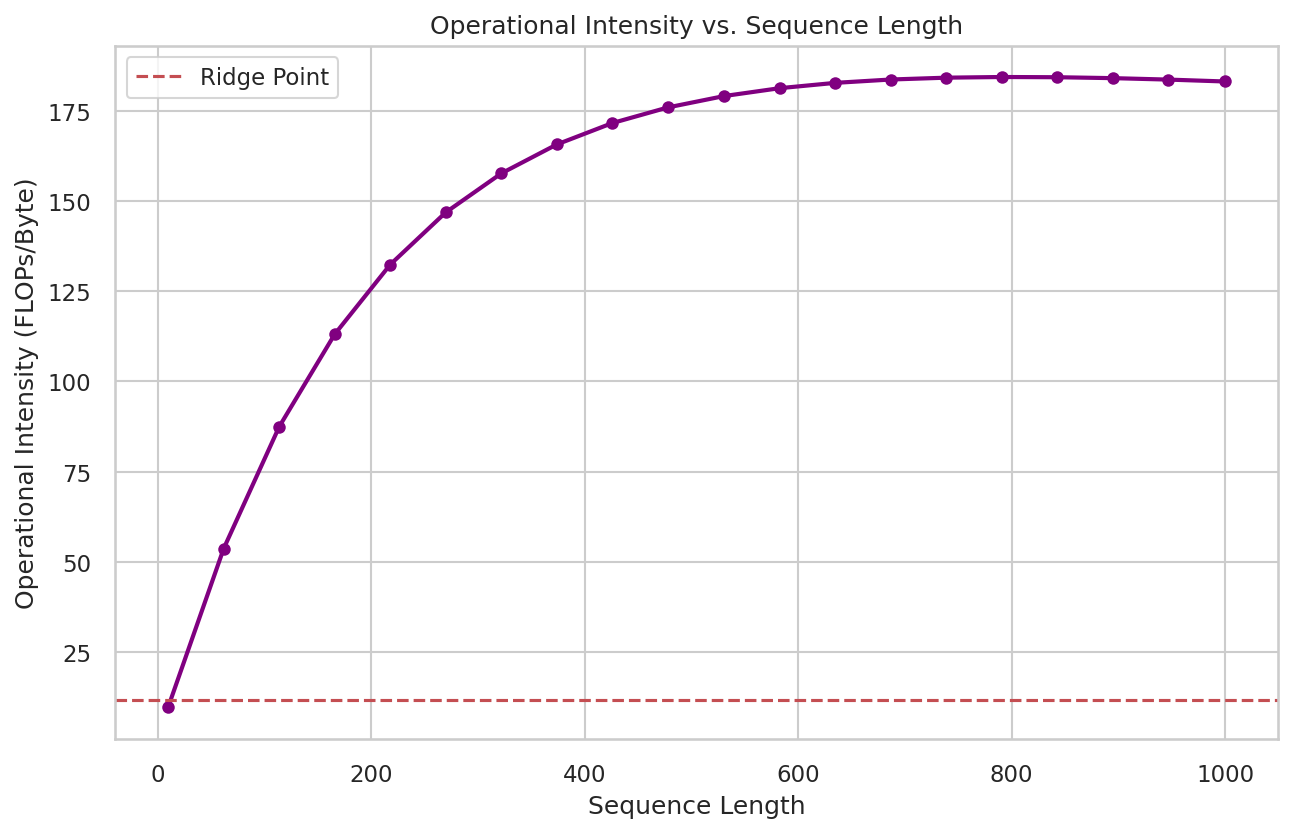

In [10]:
# Hardware Specs (U280)
FREQ = 300e6
NUM_DSP = 9024
OPS_PER_DSP = 2
P_PEAK = NUM_DSP * OPS_PER_DSP * FREQ
BW_PEAK = 460e9

def calculate_metrics(B, S, D, H):
    # QKV Proj
    flops_proj = 3 * 2 * B * S * D**2
    bytes_proj = (3 * D**2 + B * S * D + 3 * B * S * D) * 2
    
    # Attention
    D_h = D // H
    flops_attn = 2 * B * H * S**2 * D_h * 2 # Scores + Context
    bytes_attn = (2 * B * H * S * D_h + B * H * S * S + B * H * S * D_h) * 2
    
    # Out Proj
    flops_out = 2 * B * S * D**2
    bytes_out = (D**2 + B * S * D + B * S * D) * 2
    
    total_flops = flops_proj + flops_attn + flops_out
    total_bytes = bytes_proj + bytes_attn + bytes_out
    
    return total_flops / total_bytes

# Analyze OI vs Sequence Length
seq_lengths = np.linspace(10, 1000, 20).astype(int)
ois = [calculate_metrics(1, s, 768, 12) for s in seq_lengths]

plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, ois, 'o-', linewidth=2, color='purple')
plt.axhline(y=P_PEAK/BW_PEAK, color='r', linestyle='--', label='Ridge Point')
plt.xlabel('Sequence Length')
plt.ylabel('Operational Intensity (FLOPs/Byte)')
plt.title('Operational Intensity vs. Sequence Length')
plt.legend()
plt.grid(True)
plt.show()


## 5. Quantization Simulation

We simulate the effect of Int8 quantization on the layer's output accuracy.

In [11]:
def quantize_int8(tensor):
    scale = tensor.abs().max() / 127.0
    tensor_int8 = (tensor / scale).round().clamp(-128, 127).to(torch.int8)
    return tensor_int8.float() * scale

# Quantized Forward Pass
with torch.no_grad():
    # Quantize weights
    q_w_int8 = quantize_int8(model.q_proj.weight)
    # Quantize input
    x_int8 = quantize_int8(x_input)
    
    # Compute Q (Simulated)
    q_out_fp16 = torch.nn.functional.linear(x_input, model.q_proj.weight, model.q_proj.bias)
    q_out_int8 = torch.nn.functional.linear(x_int8, q_w_int8, model.q_proj.bias)
    
    # Error Metrics
    mse = torch.nn.functional.mse_loss(q_out_fp16, q_out_int8)
    cos_sim = torch.nn.functional.cosine_similarity(q_out_fp16.flatten(), q_out_int8.flatten(), dim=0)

print(f"Quantization Simulation (Q Projection):")
print(f"MSE Loss: {mse.item():.6f}")
print(f"Cosine Similarity: {cos_sim.item():.6f}")

# Visual Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(q_out_fp16.float().numpy().flatten(), bins=50, color='blue', alpha=0.5, label='FP16')
sns.histplot(q_out_int8.float().numpy().flatten(), bins=50, color='red', alpha=0.5, label='Int8 Sim')
plt.legend()
plt.title('Activation Distribution Comparison')

plt.subplot(1, 2, 2)
plt.scatter(q_out_fp16.float().numpy().flatten()[:1000], 
            q_out_int8.float().numpy().flatten()[:1000], alpha=0.5, s=5)
plt.plot([-2, 2], [-2, 2], 'k--')
plt.xlabel('FP16 Value')
plt.ylabel('Int8 Sim Value')
plt.title('Correlation Plot (Subset)')
plt.tight_layout()
plt.show()


RuntimeError: self and mat2 must have the same dtype, but got BFloat16 and Float